# Домашнее задание
Практика по PyTorch

Описание/Пошаговая инструкция выполнения домашнего задания:

1. Используя PyTorch, создать и обучить регрессионную модель, которая аппроксимирует значение функции sin(x + 2*y)exp(-(2x + y)^2) в диапазоне значений [-10;10] по х и у.
2. В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.
3. Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.
Результаты:
a) Посчитать метрику Mean Square Error(MSE) на test.
b) Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью).

Критерии оценки:
+7 балла за (a)
+3 балл за (b)
Максимальный балл: 10

# 1. Формирование dataset

In [16]:
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [17]:
# Определение функции f(x1, x2)
def f(x1, x2):
    return np.sin(x1 + 2*x2)* np.exp(-(2*x1 + x2)**2)

# Вычисление значения выражения для каждой пары массивов `X1` и `X2` (координатные
           # сетки) в диапазоне значений [-10;10] по осям х1 и х2
X1 = np.outer(np.linspace(-10, 10, 200), np.ones(200))
X2 = X1.copy().T

y = f(X1, X2)

In [18]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Surface(x=X1, y=X2, z=y, colorscale='Viridis', name='Истинные данные'))

fig.show()

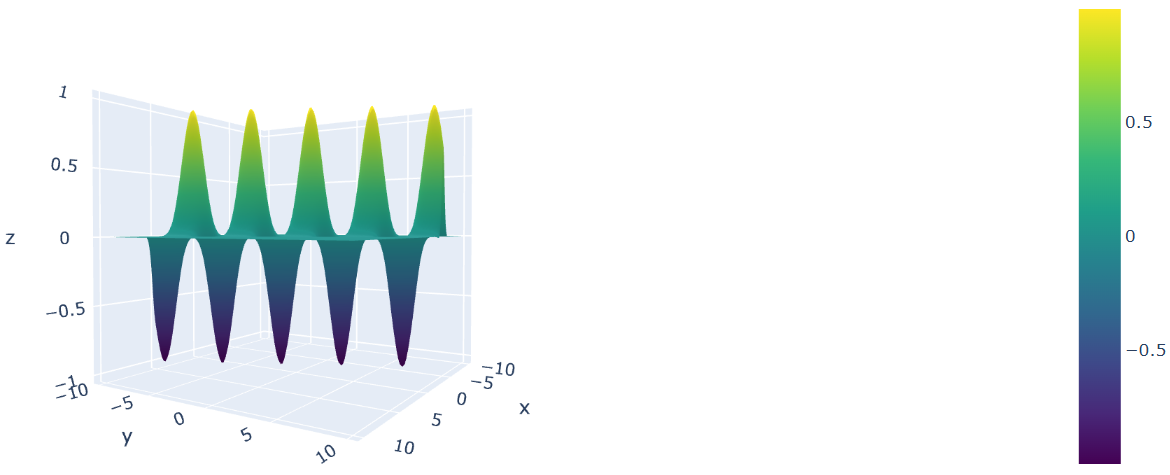

# 2. Генерация 20000 точек случайным образом в качестве обучающей выборки



In [19]:
X1 = np.linspace(-10, 10, 20000)
X2 = X1.copy()

np.random.shuffle(X1), np.random.shuffle(X2)

y = f(X1, X2)

df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})

# 3.Разделение датасета на  train / test / val


In [20]:
# 1. Разделение на train и остальной датасет
train, rest = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% rest

# 2. Разделение остального датасета (rest) на test и val
X_test, X_val, y_test, y_val = train_test_split(rest[['X1', 'X2']], rest['y'], test_size=0.5, random_state=42)

# 3. Подготовка обучающей выборки
X_train = train[['X1', 'X2']]
y_train = train['y'] + np.random.normal(0, 0.1)  # Добавление шума

# Теперь у нас есть:
# - X_train, y_train (для обучения)
# - X_test, y_test (для тестирования)
# - X_val, y_val (для валидации)

# 4.Модель


In [21]:
# Определяем структуру нейронной сети с помощью PyTorch.
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Инициализируем слои нейронной сети:
        self.fc1 = nn.Linear(2, 200) # Полносвязный слой с 2 входами и 200 выходами
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, 1) # Полносвязный слой с 200 входами и 1 выходом

    def forward(self, x):
    # Определяем процесс распространения данных через сеть:
        x = ReLU(self.fc1(x))# Пропускаем входные данные 'x' через 'fc1', затем применяем функцию активации ReLU
        x = ReLU(self.fc2(x))
        x = ReLU(self.fc3(x))
        return self.fc4(x)

# Определяем структуру для представления данных в PyTorch
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.Tensor(X.values) # Преобразуем 'X' в тензор PyTorch
        self.y = torch.from_numpy(y.values).float() # 'y' в тензор с типом float

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

# Создаем объекты датасета и загрузчиков данных:
# Создаем объекты 'MyDataset' для обучающей, тестовой и валидационной выборок
ds_train, ds_test, ds_val = MyDataset(X_train, y_train), MyDataset(X_test, y_test), MyDataset(X_val, y_val)

# Создаем объекты 'DataLoader', которые будут загружать данные из датасетов по батчам
dl_train, dl_test, dl_val = DataLoader(ds_train, batch_size=64, shuffle=True), DataLoader(ds_test, batch_size=64), DataLoader(ds_val, batch_size=64)

In [22]:
model = Model()

# 5. Обучение модели

Используем оптимизатор Adam c learning rate = 0.001 и функцию потерь MSELoss

In [24]:
ReLU = nn.ReLU()
loss_func = nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

def train(dl, epoch):
    model.train()
    for ep in range(epoch):
        print(f'Epoch {ep+1} \n -------------------')
        for batch, (X, y) in enumerate(dl):
            X, y = X.to(device), y.to(device)

            # Делаем предсказания:
            pred = model(X)
            loss = loss_func(pred.squeeze(), y)

            # Backpropagation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 50 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{len(ds_train):>5d}]")

        preds, true = test(dl_test)
        print(f'MSE = {loss_func(preds.squeeze(), true).item()}\n')


def test(dl):
    model.eval()
    preds, true = torch.empty(0), torch.empty(0)
    with torch.no_grad():
        for batch, (X, y) in enumerate(dl):
            X, y = X.to(device), y.to(device)

            # Делаем предсказания:
            pred = model(X)
            preds = torch.cat([preds, pred], 0)
            true = torch.cat([true, y], 0)
    return preds, true

In [25]:
train(dl_train, 20)

Epoch 1 
 -------------------
loss: 0.047091  [    0/14000]
loss: 0.012313  [ 3200/14000]
loss: 0.048868  [ 6400/14000]
loss: 0.003224  [ 9600/14000]
loss: 0.008681  [12800/14000]
MSE = 0.046780750155448914

Epoch 2 
 -------------------
loss: 0.009001  [    0/14000]
loss: 0.008712  [ 3200/14000]
loss: 0.016980  [ 6400/14000]
loss: 0.021297  [ 9600/14000]
loss: 0.015348  [12800/14000]
MSE = 0.047154415398836136

Epoch 3 
 -------------------
loss: 0.012263  [    0/14000]
loss: 0.026499  [ 3200/14000]
loss: 0.004395  [ 6400/14000]
loss: 0.000911  [ 9600/14000]
loss: 0.021528  [12800/14000]
MSE = 0.05025861784815788

Epoch 4 
 -------------------
loss: 0.045567  [    0/14000]
loss: 0.006349  [ 3200/14000]
loss: 0.014571  [ 6400/14000]
loss: 0.006305  [ 9600/14000]
loss: 0.037132  [12800/14000]
MSE = 0.04039604961872101

Epoch 5 
 -------------------
loss: 0.018542  [    0/14000]
loss: 0.011962  [ 3200/14000]
loss: 0.002107  [ 6400/14000]
loss: 0.010425  [ 9600/14000]
loss: 0.006516  [128

Анализ результатов обучения модели показывает, что модель обучается, но с заметными колебаниями функции потерь.

* Функция потерь:
    - Значения функции потерь (loss) значительно колеблются в каждой эпохе, демонстрируя нестабильность обучения.
    - В некоторых батчах значения loss очень низкие (например, 0.000041), а в других - значительно выше (например, 0.020961).
* MSE:
    - Среднеквадратичная ошибка (MSE) демонстрирует тенденцию к снижению в первые несколько эпох, но затем стабилизируется и незначительно колеблется.
    - Это говорит о том, что модель хоть и обучается, но не достигает стабильной оптимизации

In [26]:
preds, true = test(dl_val)
print(f'val MSE = {loss_func(preds.squeeze(), true).item()}')
X_val['y'] = preds
X_val['true'] = true
#X_val.sort_values('X1', inplace=True)

true_curve = pd.DataFrame({'X1': np.linspace(-5, 5, 2000), 'X2': -2*np.linspace(-5, 5, 2000)})
true_curve['y'] = f(true_curve['X1'], true_curve['X2'])

val MSE = 0.03616562485694885


In [27]:
# Предсказание модели
fig = go.Figure()

fig.add_trace(px.scatter_3d(X_val, x='X1', y='X2', z='y', color='y').data[0])
fig.add_trace(px.line_3d(true_curve, x='X1', y='X2', z='y').data[0])

fig.update_traces(marker_size = 3)
fig.show()

# 6.Отображение графиков истинных и предсказанных данных на валидационной выборке

In [28]:
# Определение функции для истинных данных
def f(x1, x2):
    return np.sin(x1 + 2*x2) * np.exp(-(2*x1 + x2)**2)

# Генерация сетки X1 и X2 в диапазоне значений [-10;10]
X1 = np.outer(np.linspace(-10, 10, 200), np.ones(200))
X2 = X1.copy().T
y_true = f(X1, X2)

# Вычисление предсказанных данных
preds, true = test(dl_val)  # Получите ваши предсказания
print(f'val MSE = {loss_func(preds.squeeze(), true).item()}')

# Подготовка данных для предсказаний
X_val['y'] = preds
X_val['true'] = true

# Подготовка истинной кривой
true_curve = pd.DataFrame({'X1': np.linspace(-5, 5, 2000), 'X2': -2*np.linspace(-5, 5, 2000)})
true_curve['y'] = f(true_curve['X1'], true_curve['X2'])

# Создание объекта Figure
fig = go.Figure()

# Добавление поверхности с истинными данными
fig.add_trace(go.Surface(x=X1, y=X2, z=y_true, colorscale='Viridis', name='Истинные данные', opacity=0.6))

# Добавление точек с предсказанными данными
fig.add_trace(go.Scatter3d(x=X_val['X1'], y=X_val['X2'], z=X_val['y'],
                             mode='markers',
                             marker=dict(size=5, color='blue'),
                             name='Предсказанные данные'))

# Добавление линии с истинной эпохальной кривой
fig.add_trace(go.Scatter3d(x=true_curve['X1'],
                             y=true_curve['X2'],
                             z=true_curve['y'],
                             mode='lines',
                             line=dict(color='red', width=4),
                             name='Истинная кривая'))

# Настройка графика
fig.update_layout(title='Сравнение истинных и предсказанных данных',
                  scene=dict(zaxis_title='Значение'))
fig.show()

val MSE = 0.03616562485694885


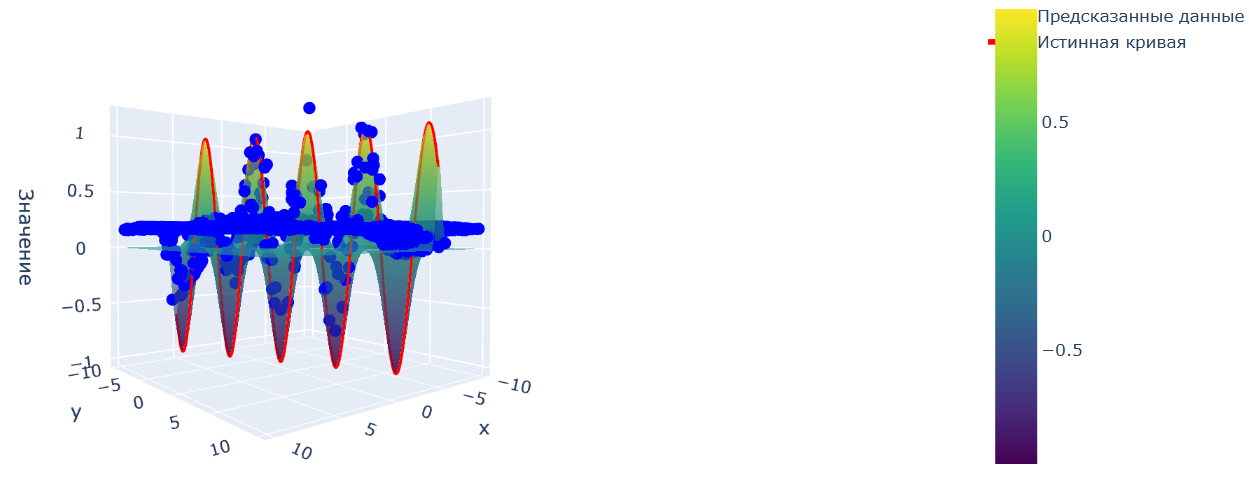

Интерпретация MSE:
- 0.03 - это довольно небольшое значение MSE. Это может говорить о том, что модель довольно хорошо описывает зависимость между переменными.

- Валидационные данные не использовались в процессе обучения, поэтому эта ошибка показывает, насколько хорошо модель обобщается на новые данные, которые она еще не видела